In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import cv2
from tqdm import tqdm

In [2]:
import torch
import numpy as np
from torch import nn

In [3]:


def createData(lenData):
    X = []
    y = []
    for i in range(lenData):
        dataLen = np.random.randint(2,20)
        dataSample = torch.tensor([])
        
        i1 =  np.random.randint(dataLen)
        i2 = np.random.randint(dataLen)
        
        # To ensure i1!=i2
        while i1 == i2:
            i2 = np.random.randint(dataLen)        

        # Creating y value
        for j in range(dataLen):
            valAdd = 0
            if j == i1 or j==i2:
                valAdd = 1
            # 2 dimension of each input segment
            dataSample = torch.cat((dataSample,torch.tensor([[torch.rand(1),valAdd]]) ), dim=0)

        
        X.append(dataSample)
        y.append(dataSample[i1,0]+dataSample[i2,0])
        
    y = torch.tensor(y)
    return X,y


In [4]:
# Creating Dataset
X_train,y_train = createData(5000)
X_val,y_val = createData(1000)
X_test,y_test = createData(1000)

In [5]:
torch.manual_seed(200)

### RNN

In [6]:
class RNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        # Using Xavier Initialization for weights
        # Input to hidden
        self.Wxh = nn.Parameter(torch.randn((2,2),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        self.bxh = nn.Parameter(torch.randn((2,1),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))

        # Hidden to hidden
        self.Whh = nn.Parameter(torch.randn((2,2),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        self.bhh = nn.Parameter(torch.randn((2,1),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        
        # Hidden to output
        self.Who = nn.Parameter(torch.randn((1,2),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(1.0))))
        self.bho = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(1.0))))

    def forward(self,x) -> torch.Tensor:
        ht0 = torch.tensor([0,0],dtype=torch.float32).unsqueeze(dim=1)
        # Iterating through each input sequence
        for i in range(x.shape[0]):
            
            ht = nn.Tanh()(self.Wxh @ x[i].unsqueeze(dim=1) + self.bxh + self.Whh @ ht0 + self.bhh)
            
            
            ht0 = ht
        yhat = (self.Who @ ht + self.bho) 
        return yhat


In [7]:
rnn1 = RNN()

In [8]:
# Testing the forward pass
rnn1.forward(X_train[100])

tensor([[-0.8195]], grad_fn=<AddBackward0>)

In [9]:
loss_fn = nn.MSELoss()
optimizer_rnn = torch.optim.Adam(params=rnn1.parameters(),lr=0.01)

In [10]:
def loss_plotter(train_loss,val_loss=None,modelName = ''):
    epochs = len(train_loss)
    x = [i for i in range(epochs)]
    plt.figure(figsize=(10,7))
    plt.title(f'{modelName} Loss Plot')
    plt.plot(x,train_loss,c='b',label="Training loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    if val_loss:
        plt.plot(x,val_loss,c='r',label="Validation loss")
        plt.xlabel('Epochs')


    plt.legend()

In [11]:
epochs = 15


history_rnn = {'training_loss':[],'val_loss':[]}

for epoch in tqdm(range(epochs)):
    rnn1.train()
    epochLoss_rnn = []
    for i in range(len(X_train)):
        y_logits = rnn1.forward(X_train[i]).squeeze()
 
        loss = loss_fn(y_logits,y_train[i].squeeze())
        cpuLoss = loss.cpu().detach().numpy()
        epochLoss_rnn.append(cpuLoss)
        # history['training_accuracy'].append()

        optimizer_rnn.zero_grad()

        loss.backward()

        optimizer_rnn.step()
    epochLoss_rnn = np.array(epochLoss_rnn)
    MSE = np.mean(epochLoss_rnn)
    print(f'training loss: {MSE}',end='\t')

    history_rnn['training_loss'].append(MSE)

    
    epochLoss_rnn_val = []
    rnn1.eval()

    with torch.inference_mode():
       for i in range(len(X_val)):
            y_logits = rnn1.forward(X_val[i]).squeeze()
    
            loss = loss_fn(y_logits,y_val[i].squeeze())
            cpuLoss = loss.cpu().detach().numpy()
            epochLoss_rnn_val.append(cpuLoss)

    epochLoss_rnn_val = np.array(epochLoss_rnn_val)
    MSE = np.mean(epochLoss_rnn_val)
    print(f'val loss: {MSE}')
    history_rnn['val_loss'].append(MSE)

    # Stopping if Val loss goes below 0.05
    if MSE<0.5*1e-2:
        print("Early Stopping...")
        break

    



  7%|▋         | 1/15 [00:03<00:49,  3.57s/it]

training loss: 0.18412016332149506	val loss: 0.14862960577011108


 13%|█▎        | 2/15 [00:07<00:46,  3.55s/it]

training loss: 0.14804860949516296	val loss: 0.14011700451374054


 20%|██        | 3/15 [00:10<00:42,  3.54s/it]

training loss: 0.1409500688314438	val loss: 0.1354282796382904


 27%|██▋       | 4/15 [00:14<00:38,  3.54s/it]

training loss: 0.12887734174728394	val loss: 0.13752157986164093


 33%|███▎      | 5/15 [00:17<00:35,  3.55s/it]

training loss: 0.08275902271270752	val loss: 0.06242948770523071


 40%|████      | 6/15 [00:21<00:31,  3.55s/it]

training loss: 0.1157187968492508	val loss: 0.12279918044805527


 47%|████▋     | 7/15 [00:24<00:28,  3.55s/it]

training loss: 0.12807676196098328	val loss: 0.08585252612829208


 53%|█████▎    | 8/15 [00:28<00:25,  3.58s/it]

training loss: 0.09062184393405914	val loss: 0.05282211676239967


 60%|██████    | 9/15 [00:32<00:21,  3.57s/it]

training loss: 0.08241911977529526	val loss: 0.10731631517410278


 67%|██████▋   | 10/15 [00:35<00:17,  3.57s/it]

training loss: 0.10223214328289032	val loss: 0.1298937350511551


 73%|███████▎  | 11/15 [00:39<00:14,  3.56s/it]

training loss: 0.06884285807609558	val loss: 0.13150164484977722


 80%|████████  | 12/15 [00:42<00:10,  3.56s/it]

training loss: 0.0737612321972847	val loss: 0.15264037251472473


 87%|████████▋ | 13/15 [00:46<00:07,  3.56s/it]

training loss: 0.07291387021541595	val loss: 0.0619828999042511


 93%|█████████▎| 14/15 [00:49<00:03,  3.58s/it]

training loss: 0.06286008656024933	val loss: 0.08758161216974258


100%|██████████| 15/15 [00:53<00:00,  3.56s/it]

training loss: 0.07542073726654053	val loss: 0.05491301044821739


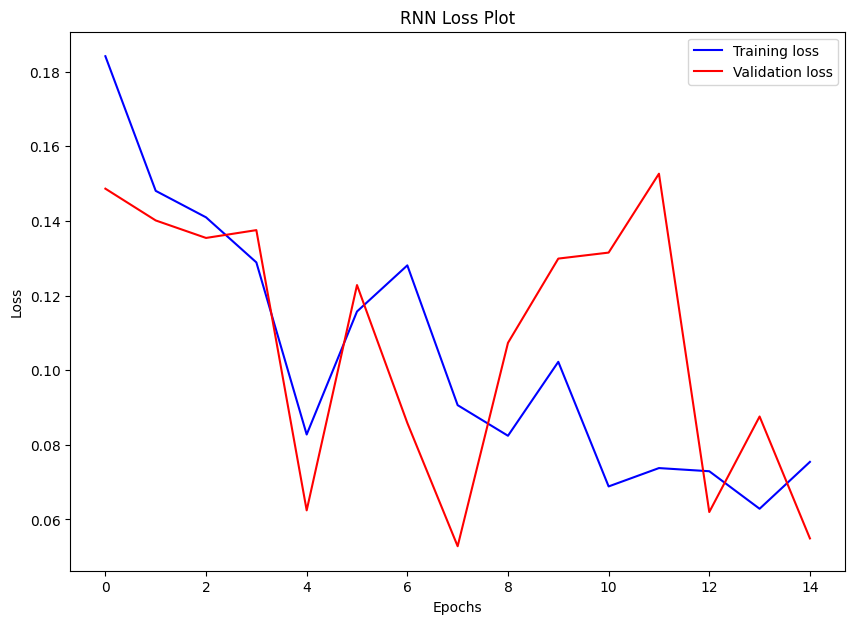

In [12]:
loss_plotter(history_rnn['training_loss'],history_rnn['val_loss'],modelName='RNN')

In [13]:
rnn1.eval()
epochLoss_rnn_test = []
with torch.inference_mode():
    for i in range(len(X_test)):
        y_logits = rnn1.forward(X_test[i]).squeeze()

        loss = loss_fn(y_logits,y_test[i].squeeze())
        cpuLoss = loss.cpu().detach().numpy()
        epochLoss_rnn_test.append(cpuLoss)

epochLoss_rnn_test = np.array(epochLoss_rnn_test)
MSE = np.mean(epochLoss_rnn_test)
print(f'RNN Test loss: {MSE}')


RNN Test loss: 0.05657219514250755


### LSTM

In [14]:
class LSTM2(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # Forget Gate
        self.Wf = nn.Parameter(torch.randn((2,4),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        self.bf = nn.Parameter(torch.randn((2,1),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))

        # Input Gate
        self.Wi = nn.Parameter(torch.randn((2,4),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        self.bi = nn.Parameter(torch.randn((2,1),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        
        # Candidate Solution
        self.Wc = nn.Parameter(torch.randn((2,4),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        self.bc = nn.Parameter(torch.randn((2,1),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        
        # Output Gate
        self.Wo = nn.Parameter(torch.randn((2,4),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        self.bo = nn.Parameter(torch.randn((2,1),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))

        # Output Gate to yHat
        self.Who = nn.Parameter(torch.randn((1,2),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(1.0))))
        self.bho = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(1.0))))

    def forward(self,x) -> torch.Tensor:
        ht0 = torch.tensor([0,0],dtype=torch.float32).unsqueeze(dim=1)
        ct0 = torch.tensor([0,0],dtype=torch.float32).unsqueeze(dim=1)

        for i in range(x.shape[0]):
            
            ft = nn.Sigmoid()(self.Wf @ (torch.cat((ht0,x[i].unsqueeze(dim=-1)),dim=0)) + self.bf)    

            it = nn.Sigmoid()(self.Wi @ (torch.cat((ht0,x[i].unsqueeze(dim=-1)),dim=0)) + self.bi)
            
            c_tilda = nn.Tanh()(self.Wc @ (torch.cat((ht0,x[i].unsqueeze(dim=-1)),dim=0)) + self.bc)


            ct = ft * ct0 + it* c_tilda

            ot = nn.Sigmoid()(self.Wo @ (torch.cat((ht0,x[i].unsqueeze(dim=-1)),dim=0)) + self.bo)
            ct0=ct
            
            
            ht = ot * nn.Tanh()(ct)
            ht0 = ht

        inter_out = self.Who @ ht
        yHat = inter_out

        return yHat

In [15]:
lstm = LSTM2()
lstm.forward(X_train[0])

tensor([[-0.1578]], grad_fn=<MmBackward0>)

In [16]:
loss_fn = nn.MSELoss()

optimizer_lstm = torch.optim.Adam(params=lstm.parameters(),lr=0.01)

In [17]:
lstm.state_dict()

OrderedDict([('Wf',
              tensor([[-0.4995,  0.1194, -0.1439, -0.2736],
                      [-0.4892,  0.0038, -0.8688,  0.7654]])),
             ('bf',
              tensor([[-0.3669],
                      [ 0.2606]])),
             ('Wi',
              tensor([[-1.7857,  0.8593, -0.0885, -1.6013],
                      [-0.2855, -1.2638,  0.3303,  0.6978]])),
             ('bi',
              tensor([[-0.4649],
                      [ 0.6447]])),
             ('Wc',
              tensor([[ 1.3610, -0.4759,  0.6202, -0.5108],
                      [ 1.4212, -0.3690,  0.3157,  1.0138]])),
             ('bc',
              tensor([[-0.2216],
                      [ 0.5127]])),
             ('Wo',
              tensor([[ 0.0022, -0.2460,  2.0908,  0.5914],
                      [ 0.2160, -1.4333,  1.5233,  1.0437]])),
             ('bo',
              tensor([[-0.7757],
                      [ 1.1029]])),
             ('Who', tensor([[1.2031, 0.0319]])),
             ('bho', t

In [18]:
epochs = 5

history_lstm = {'training_loss':[],'val_loss':[],'training_accuracy':[],'test_accuracy':[]}

for epoch in tqdm(range(epochs)):
    lstm.train()
    epochLoss_lstm = []
    for i in range(len(X_train)):
        y_logits = lstm.forward(X_train[i]).squeeze()
 
        loss = loss_fn(y_logits,y_train[i].squeeze())
        cpuLoss = loss.cpu().detach().numpy()
        epochLoss_lstm.append(cpuLoss)
        optimizer_lstm.zero_grad()

        loss.backward()

        optimizer_lstm.step()
    epochLoss_lstm = np.array(epochLoss_lstm)
    MSE = np.mean(epochLoss_lstm)
    print(f'training loss: {MSE}',end='\t')

    history_lstm['training_loss'].append(MSE)

    epochLoss_lstm_val = []
    lstm.eval()

    with torch.inference_mode():
       for i in range(len(X_val)):
            y_logits = lstm.forward(X_val[i]).squeeze()
    
            loss = loss_fn(y_logits,y_val[i].squeeze())
            cpuLoss = loss.cpu().detach().numpy()
            epochLoss_lstm_val.append(cpuLoss)

    epochLoss_lstm_val = np.array(epochLoss_lstm_val)
    MSE = np.mean(epochLoss_lstm_val)
    print(f'val loss: {MSE}')

    history_lstm['val_loss'].append(MSE)

    # Stopping if Val loss goes below 0.005
    if MSE<0.5*1e-2:
        print("Early Stopping...")
        break

  0%|          | 0/5 [00:00<?, ?it/s]

training loss: 0.09824288636445999	

 20%|██        | 1/5 [00:11<00:47, 11.97s/it]

val loss: 0.024365080520510674
training loss: 0.017068825662136078	

 40%|████      | 2/5 [00:23<00:34, 11.57s/it]

val loss: 0.008590390905737877
training loss: 0.009580854326486588	

 60%|██████    | 3/5 [00:34<00:23, 11.61s/it]

val loss: 0.005204986780881882
training loss: 0.006017734296619892	

 80%|████████  | 4/5 [00:45<00:11, 11.37s/it]

val loss: 0.005064443685114384
training loss: 0.003917774185538292	

 80%|████████  | 4/5 [00:56<00:14, 14.23s/it]

val loss: 0.0037516988813877106
Early Stopping...


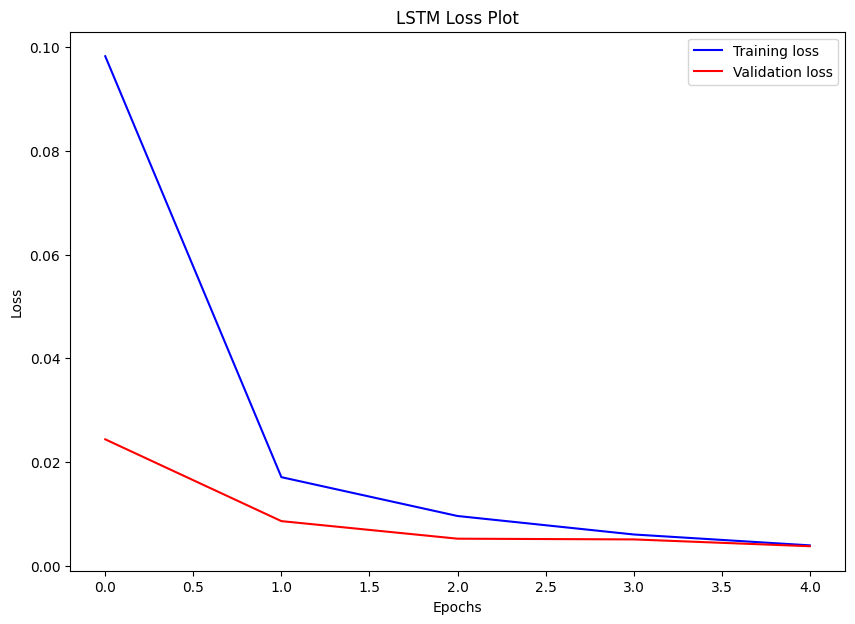

In [19]:
loss_plotter(history_lstm['training_loss'],history_lstm['val_loss'],modelName='LSTM')

In [20]:
lstm.eval()
epochLoss_lstm_test = []
with torch.inference_mode():
    for i in range(len(X_test)):
        y_logits = lstm.forward(X_test[i]).squeeze()

        loss = loss_fn(y_logits,y_test[i].squeeze())
        cpuLoss = loss.cpu().detach().numpy()
        epochLoss_lstm_test.append(cpuLoss)

epochLoss_lstm_test = np.array(epochLoss_lstm_test)
MSE = np.mean(epochLoss_lstm_test)
print(f'LSTM Test loss: {MSE}')


LSTM Test loss: 0.003806191496551037


### GRU

In [21]:
class GRU(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.Wz = nn.Parameter(torch.randn((2,4),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        self.bz = nn.Parameter(torch.randn((2,1),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))

        # Reset Gate
        self.Wr = nn.Parameter(torch.randn((2,4),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        self.br = nn.Parameter(torch.randn((2,1),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        
        self.W = nn.Parameter(torch.randn((2,4),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        self.b = nn.Parameter(torch.randn((2,1),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(2.0))))
        
        # hidden to output
        self.Who = nn.Parameter(torch.randn((1,2),requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(1.0))))
        self.bho = nn.Parameter(torch.randn(1,requires_grad=True,dtype=torch.float)/(torch.sqrt(torch.tensor(1.0))))

    def forward(self,x) -> torch.Tensor:
        ht0 = torch.tensor([0,0],dtype=torch.float32).unsqueeze(dim=-1)
       
        for i in range(x.shape[0]):
            
            zt = nn.Sigmoid()(self.Wz @ (torch.cat((ht0,x[i].unsqueeze(dim=-1)),dim=0)) + self.bz)
            
            rt = nn.Sigmoid()(self.Wr @ (torch.cat((ht0,x[i].unsqueeze(dim=-1)),dim=0)) + self.br)
            

            h_tilda = nn.Tanh()(self.W @ (  torch.cat(( (rt*ht0),x[i].unsqueeze(dim=1)),dim=0)) + self.b)

            ht = (1-zt)*ht0 + zt * h_tilda
            ht0 = ht

        yHat = self.Who @ (ht)+ self.bho
        return yHat

In [22]:
gru = GRU()
gru.forward(X_train[0])

tensor([[-0.5759]], grad_fn=<AddBackward0>)

In [23]:
loss_fn = nn.MSELoss()

optimizer_gru = torch.optim.Adam(params=gru.parameters(),lr=1e-3)

In [24]:
gru.state_dict()

OrderedDict([('Wz',
              tensor([[ 1.0583,  0.4162, -0.0779, -0.2983],
                      [-0.5386, -0.4398,  0.2828, -0.8648]])),
             ('bz',
              tensor([[-0.1861],
                      [ 1.1638]])),
             ('Wr',
              tensor([[-0.1034, -0.2954,  0.0761, -0.5773],
                      [ 0.1665, -0.0851, -0.2844,  0.1255]])),
             ('br',
              tensor([[ 0.0441],
                      [-0.1515]])),
             ('W',
              tensor([[ 0.2494,  0.5327, -0.0315, -0.2478],
                      [ 0.3976, -0.9227,  0.1106,  0.1190]])),
             ('b',
              tensor([[1.2016],
                      [0.7257]])),
             ('Who', tensor([[-1.2941,  0.6671]])),
             ('bho', tensor([0.1706]))])

In [25]:
epochs = 15

history_gru = {'training_loss':[],'val_loss':[]}

for epoch in tqdm(range(epochs)):
    gru.train()
    epochLoss_gru= []
    for i in range(len(X_train)):
        y_logits = gru.forward(X_train[i]).squeeze()
 
        loss = loss_fn(y_logits,y_train[i].squeeze())
        cpuLoss = loss.cpu().detach().numpy()
        epochLoss_gru.append(cpuLoss)

        optimizer_gru.zero_grad()

        loss.backward()

        optimizer_gru.step()
    epochLoss_gru = np.array(epochLoss_gru)
    MSE = np.mean(epochLoss_gru)
    print(f'training loss: {MSE}',end='\t')

    history_gru['training_loss'].append(MSE)


    epochLoss_gru_val = []
    gru.eval()

    with torch.inference_mode():
       for i in range(len(X_val)):
            y_logits = gru.forward(X_val[i]).squeeze()
    
            loss = loss_fn(y_logits,y_val[i].squeeze())
            cpuLoss = loss.cpu().detach().numpy()
            epochLoss_gru_val.append(cpuLoss)

    epochLoss_gru_val = np.array(epochLoss_gru_val)
    MSE = np.mean(epochLoss_gru_val)
    print(f'val loss: {MSE}')

    history_gru['val_loss'].append(MSE)
    
    # Stopping if Val loss goes below 0.005
    if MSE<0.5*1e-2:
        print("Early Stopping...")
        break

  0%|          | 0/15 [00:00<?, ?it/s]

training loss: 0.228706493973732	

  7%|▋         | 1/15 [00:09<02:11,  9.41s/it]

val loss: 0.14087769389152527
training loss: 0.1017143726348877	

 13%|█▎        | 2/15 [00:18<02:00,  9.27s/it]

val loss: 0.03462760150432587
training loss: 0.013145322911441326	

 20%|██        | 3/15 [00:27<01:50,  9.21s/it]

val loss: 0.005913314875215292
training loss: 0.004190762992948294	

 20%|██        | 3/15 [00:36<02:27, 12.27s/it]

val loss: 0.00259714899584651
Early Stopping...


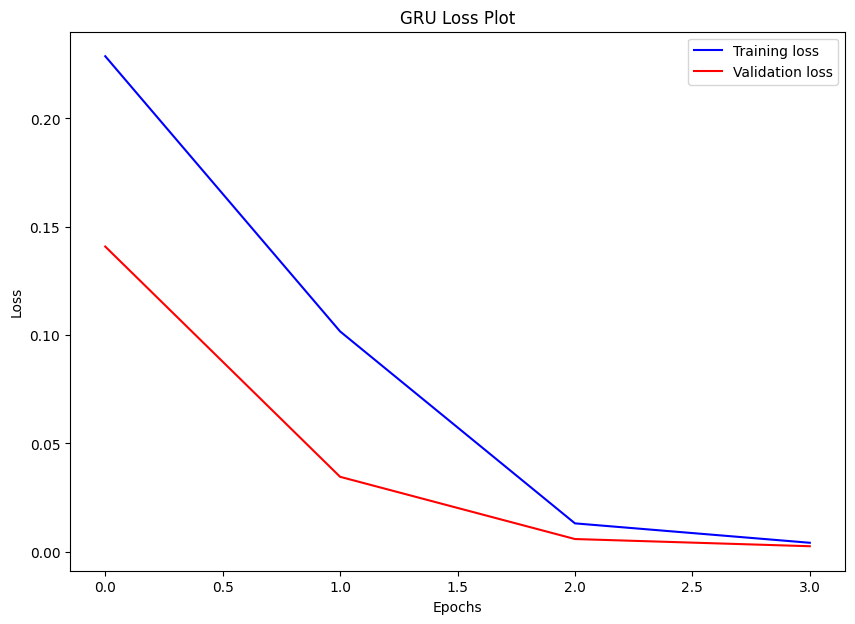

In [26]:
loss_plotter(history_gru['training_loss'],history_gru['val_loss'],modelName='GRU')

In [27]:
gru.eval()
epochLoss_gru_test = []
with torch.inference_mode():
    for i in range(len(X_test)):
        y_logits = gru.forward(X_test[i]).squeeze()

        loss = loss_fn(y_logits,y_test[i].squeeze())
        cpuLoss = loss.cpu().detach().numpy()
        epochLoss_gru_test.append(cpuLoss)

epochLoss_gru_test = np.array(epochLoss_gru_test)
MSE = np.mean(epochLoss_gru_test)
print(f'GRU Test loss: {MSE}')


GRU Test loss: 0.0029420615173876286


### Comparison

In [28]:
import plotly.graph_objects as pltint


def runInference(dataset=0):
    '''
    dataset: 0 -> train, 1-> val, 2-> test
    '''

    if dataset==0:
        X = X_train
        y = y_train
        titleLabel = 'training'
    elif dataset ==1:
        X=X_val
        y=y_val
        titleLabel = 'validation'
    else:
        X = X_test
        y =y_test
        titleLabel = 'testing'

    sqErrs_1 = []
    sqErrs_2 = []
    sqErrs_3 = []
    sqErrs_4 = []

    for i in range(len(X)):
        err1 = 1-y[i].item()

        sqErrs_1.append((err1)**2)
        with torch.inference_mode():
            y_logits = rnn1.forward(X[i]).squeeze()
            err2 = y_logits.item()-y[i].item()
            sqErrs_2.append((err2)**2)

            y_logits = lstm.forward(X[i]).squeeze()
            err3 = y_logits.item()-y[i].item()
            sqErrs_3.append((err3)**2)

            y_logits = gru.forward(X[i]).squeeze()
            err4 = y_logits.item()-y[i].item()
            sqErrs_4.append((err4)**2)


    sqErrs_1 = np.array(sqErrs_1)
    sqErrs_2 = np.array(sqErrs_2)
    sqErrs_3 = np.array(sqErrs_3)
    sqErrs_4 = np.array(sqErrs_4)

    
    x = np.arange(len(sqErrs_1))


    trace1 = pltint.Scatter(
        x = x,
        y = sqErrs_1,
        mode = 'lines',
        name = 'Baseline'
    )
    trace2 = pltint.Scatter(
        x = x,
        y = sqErrs_2,
        mode = 'lines',
        name = 'RNN'
    )

    trace3 = pltint.Scatter(
        x = x,
        y = sqErrs_3,
        mode = 'lines',
        name = 'LSTM'
    )

    trace4 = pltint.Scatter(
        x = x,
        y = sqErrs_4,
        mode = 'lines',
        name = 'GRU'
    )

    data = [trace1, trace2,trace3,trace4]
    
    

    layout = pltint.Layout(
        title=f'Line Plot of Baseline,RNN,LSTM,GRU for {titleLabel} data',
        xaxis=dict(title='Datapoints'),
        yaxis=dict(title='Squared Error'),
        legend=dict(title='Legend'),
        hovermode='closest'
    )


    fig = pltint.Figure(data=data, layout=layout)
    fig.show()


In [29]:
runInference(dataset=0)

Conclusion:
Loss -> RNN>GRU=LSTM